In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#trainset
dataset = pd.read_csv("/data/fjsdata/physionet/eICU-CRD/EMBC2020/trainset.csv",sep=',',index_col=['patientunitstayid']) 
#min-max scale the continous features
ss = MinMaxScaler()
scale_features = ['ph', 'creatinine', 'albumin','diagnosis']
dataset[scale_features] = ss.fit_transform(dataset[scale_features])
X_data = dataset.drop(columns=["actualiculos"], inplace=False)  #feature
y_data = dataset['actualiculos']#label
print ('The shape of trainset is : %d,%d'%(X_data.shape[0],X_data.shape[1]))

#testset
testset = pd.read_csv("/data/fjsdata/physionet/eICU-CRD/EMBC2020/testset.csv",sep=',',index_col=['patientunitstayid'])
testset[scale_features] = ss.fit_transform(testset[scale_features])
X_test = testset.drop(columns=["actualiculos"], inplace=False)  #feature
y_test = testset['actualiculos']#label 
print ('The shape of testset is : %d,%d'%(X_test.shape[0],X_test.shape[1]))

The shape of trainset is : 108988,52
The shape of testset is : 27248,52


In [2]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score,mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV

mae_train_L1 = []
mae_test_L1 = []
for ratio in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    _, X_train, _, y_train = train_test_split(X_data, y_data, test_size=ratio, random_state=1)
    #training model
    param_grid = {'fit_intercept':[True,False],'alpha':[0.01,0.05,0.1,0.5]}
    clf = linear_model.Lasso(normalize=False,random_state=0) #max_iter
    grid_clf = GridSearchCV(clf, param_grid, cv=5)
    grid_clf.fit(X_train, y_train.ravel())
    #Trainset performance
    y_pred_train = grid_clf.predict(X_train)
    mae_train_L1.append( mean_absolute_error(y_train, y_pred_train) )
    # testset performance
    y_pred_test = grid_clf.predict(X_test)
    mae_test_L1.append( mean_absolute_error(y_test, y_pred_test) )
print(mae_train_L1)
print(mae_test_L1)

[1.954799759413699, 1.986307013381426, 1.9545513709535347, 1.9757450711956877, 1.9849369540576767, 1.9906090132725374, 1.9978681419068332, 1.9919666146823416, 1.997836094724669]
[2.008382974280548, 2.014470618339988, 2.007605168303357, 2.0120878684614887, 2.0131245087326475, 2.0118350430895275, 2.0133627847882374, 2.0105910577848927, 2.0119863105358182]


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score,mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV

mae_train_RF = []
mae_test_RF = []
for ratio in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    _, X_train, _, y_train = train_test_split(X_data, y_data, test_size=ratio, random_state=1)
    #1. training model
    param_grid = { 'n_estimators': [5, 10, 15, 20], 'max_depth': [10, 20, 30, 50] }
    clf = RandomForestRegressor(max_features='sqrt', min_samples_split=110, min_samples_leaf=20, oob_score=False, random_state=0)
    grid_clf = GridSearchCV(clf, param_grid, cv=5)
    grid_clf.fit(X_train, y_train.ravel())
    #Trainset performance
    y_pred_train = grid_clf.predict(X_train)
    mae_train_RF.append( mean_absolute_error(y_train, y_pred_train) )
    # testset performance
    y_pred_test = grid_clf.predict(X_test)
    mae_test_RF.append( mean_absolute_error(y_test, y_pred_test) )
print(mae_train_RF)
print(mae_test_RF)

[1.8601690855082136, 1.8777973423724934, 1.84337167683658, 1.8575884931077602, 1.8662624267044454, 1.8718551778566352, 1.8787754109322032, 1.869157461168454, 1.8775846351610546]
[1.9936199875371128, 1.9913957157472741, 1.9741646241583548, 1.9714473253359688, 1.976118453787452, 1.9743699900692537, 1.9729100296986648, 1.9706030031965551, 1.9687247744971303]


In [30]:
import pandas as pd
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score,mean_squared_error
print (torch.cuda.is_available())
print (torch.version.cuda)
print (torch.cuda.get_device_name(torch.cuda.current_device()))
#model
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)
    
class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
    
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
    def forward(self, x):
        # sample gaussian noise for each weight
        weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())      
        # calculate the weight stds from the rho parameters
        weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
        # calculate samples from the posterior from the sampled noise and mus/stds
        weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
        torch.cuda.synchronize()
        output = torch.mm(x, weight_sample)
            
        # computing the KL loss term
        #reference: https://github.com/jojonki/AutoEncoders/blob/master/kl_divergence_between_two_gaussians.pdf
        prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
        KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
        KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
        KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
        return output, KL_loss
    
class BBP_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 3))
        self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 3))
        self.layer3 = BayesLinear_Normalq(num_units[1], output_dim, gaussian(0, 3))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        # noise
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([3]))
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer3(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        return x, KL_loss_total
    
class BBP_Model_Wrapper:
    def __init__(self, network, learn_rate=1e-2):
        
        self.learn_rate = learn_rate
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss#nn.MSELoss() 
    
    def fit(self, x, y, no_samples):
        
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        KL_loss_total = 0
        for i in range(no_samples):
            output, KL_loss = self.network(x)
            KL_loss_total = KL_loss_total + KL_loss
            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output, y, self.network.log_noise.exp(), 1) 
            fit_loss_total = fit_loss_total + fit_loss
        
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return total_loss
    
#1.training model
mae_train_bnn = []
mae_test_bnn = []
for ratio in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    _, X_train, _, y_train = train_test_split(X_data, y_data, test_size=ratio, random_state=1)
    num_epochs = 300
    log_every=10
    best_net, best_loss = None, float('inf')
    net = BBP_Model_Wrapper(network=BBP_Model(input_dim=X_data.shape[1], output_dim=1, num_units=[16,4]))
    for i in range(num_epochs):
        total_loss = net.fit(np.array(X_train), np.array(y_train.to_frame()), no_samples = 100)

        if total_loss < best_loss:
            best_loss = total_loss
            best_net = copy.deepcopy(net.network)
    #2. trainset performance
    X_train_cuda, y_train_cuda = to_variable(var=(np.array(X_train), np.array(y_train.to_frame())), cuda=True)
    y_pred_train = []
    for i in range(100):#sample
        output, KL_loss = best_net(X_train_cuda)
        y_pred_train.append(output.cpu().data.numpy())
    y_pred_train = np.array(y_pred_train).mean(axis=0)    
    mae_train_bnn.append(mean_absolute_error(y_train, y_pred_train))

    #3. testset performance
    X_test_cuda, y_test_cuda = to_variable(var=(np.array(X_test), np.array(y_test.to_frame())), cuda=True)
    y_pred_test= []
    for i in range(100):#sample
        output, KL_loss = best_net(X_test_cuda)
        y_pred_test.append(output.cpu().data.numpy())
    y_pred_test = np.array(y_pred_test).mean(axis=0)  
    mae_test_bnn.append(mean_absolute_error(y_test, y_pred_test))
print(mae_train_bnn)
print(mae_test_bnn)

True
9.0.176
GeForce RTX 2080 Ti
[1.8773726597761278, 1.9816650205454418, 1.938396097106877, 1.9361697791753463, 1.9676932355099548, 1.9863413193929957, 1.9881572332538542, 1.9456237571486417, 1.966836028752934]
[1.9498400092067891, 2.014825303106709, 2.028154898544654, 1.9779191164768064, 1.9955422601035497, 1.9971325473073156, 2.0016078129250023, 1.9624499715274144, 1.9921624493698615]


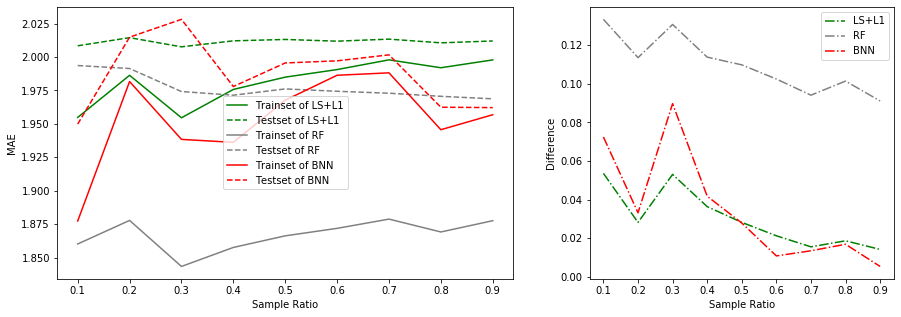

In [46]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
x_axis = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])

mae_train_bnn = [1.8773726597761278, 1.9816650205454418, 1.938396097106877, 1.9361697791753463, 1.9676932355099548, 1.9863413193929957, 1.9881572332538542, 1.9456237571486417, 1.956836028752934]
mae_test_bnn = [1.9498400092067891, 2.014825303106709, 2.028154898544654, 1.9779191164768064, 1.9955422601035497, 1.9971325473073156, 2.0016078129250023, 1.9624499715274144, 1.9621624493698615]

plt.subplot(gs[0])
plt.plot(x_axis, mae_train_L1, color='green', linestyle ='-', label='Trainset of LS+L1')
plt.plot(x_axis, mae_test_L1, color='green', linestyle ='--',label='Testset of LS+L1')
plt.plot(x_axis, mae_train_RF, color='gray', linestyle ='-', label='Trainset of RF')
plt.plot(x_axis, mae_test_RF, color='gray', linestyle ='--',label='Testset of RF')
plt.plot(x_axis, mae_train_bnn, color='red', linestyle ='-', label='Trainset of BNN')
plt.plot(x_axis, mae_test_bnn, color='red', linestyle ='--',label='Testset of BNN')
plt.xlabel('Sample Ratio')
plt.ylabel('MAE')
plt.legend() 

plt.subplot(gs[1])
plt.plot(x_axis, list(map(lambda x: x[0]-x[1], zip(mae_test_L1, mae_train_L1))), color='green', linestyle ='-.',label='LS+L1')
plt.plot(x_axis, list(map(lambda x: x[0]-x[1], zip(mae_test_RF, mae_train_RF))), color='gray', linestyle ='-.',label='RF')
plt.plot(x_axis, list(map(lambda x: x[0]-x[1], zip(mae_test_bnn, mae_train_bnn))), color='red', linestyle ='-.',label='BNN')
plt.xlabel('Sample Ratio')
plt.ylabel('Difference')
plt.legend() 

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score,mean_squared_error
from math import sqrt
import tensorflow as tf
import sys
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

#DNN model
class TF_DNNRegressor_eICU:
    def __init__(self, lr=0.001, dim=52, num_class=1, batchSize=1000, layers=[16, 4]):
        #global parameters
        self.lr = lr
        self.dim = dim # dimensions of sample
        self.num_class = num_class #output 
        self.hidden_layers = layers
        #set network structure
        self.add_placeholders()
        self.add_weight()
        self.add_model()
        self.add_loss()
        self.add_optimizer()
        self.init_sess()
        
    def add_placeholders(self):    
        self.X_input = tf.placeholder("float", [None, self.dim])
        self.Y_input = tf.placeholder("float", [None, self.num_class])
        self.keep_prob = tf.placeholder(tf.float32)  
    
    def add_weight(self):
        # Store layers weight & bias
        #init_uniform = tf.random_uniform_initializer(minval=0, maxval=1, seed=None, dtype=tf.float32)
        self.weights = {
            'w1': tf.Variable(tf.random_normal([self.dim, self.hidden_layers[0]])),
            'w2': tf.Variable(tf.random_normal([self.hidden_layers[0], self.hidden_layers[1]])),
            'wout': tf.Variable(tf.random_normal([self.hidden_layers[1], self.num_class]))
        }
        self.biases = {
            'b1': tf.Variable(tf.random_normal([self.hidden_layers[0]])),
            'b2': tf.Variable(tf.random_normal([self.hidden_layers[1]])),
            'bout': tf.Variable(tf.random_normal([self.num_class]))
        }
        
    def add_model(self):
        # Hidden fully connected layer with 16 neurons
        layer_1 =  tf.add(tf.matmul(self.X_input, self.weights['w1']), self.biases['b1']) 
        # Hidden fully connected layer with 4 neurons
        layer_2 = tf.add(tf.matmul(layer_1, self.weights['w2']), self.biases['b2']) 
        # Output fully connected layer with a neuron for each class
        out_layer =tf.matmul(layer_2, self.weights['wout']) + self.biases['bout'] 
        self.Y_output =  out_layer
    
    def add_loss(self):
        self.loss = tf.losses.mean_squared_error( self.Y_input , self.Y_output ) 
         #self.loss = tf.reduce_sum(tf.losses.absolute_difference( self.Y_input , self.Y_output ) )
            
    def add_optimizer(self):
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.loss)
        
    def init_sess(self):
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        self.config.allow_soft_placement = True
        #self.config.gpu_options.per_process_gpu_memory_fraction = 0.5
        self.sess = tf.Session(config=self.config)
        self.sess.run(tf.global_variables_initializer())
        
#1.training model
mae_train_dnn = []
mae_test_dnn = []
for layer in [[8,2],[16,4],[32,8],[64,16],[128,32]]:
    tf_model = TF_DNNRegressor_eICU(layers=layer)
    #set paramete
    verbose = 10
    batchSize=1000
    num_batches = X_data.shape[0] // batchSize + 1 
    for epoch in range(200):#convergence
        losses = []
        for i in range(num_batches):
            min_idx = i * batchSize
            max_idx = np.min([X_data.shape[0], (i+1)*batchSize])
            X_batch = X_data[min_idx: max_idx]
            Y_batch = y_data.to_frame()[min_idx: max_idx]
            _, tmp_loss,  = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                             feed_dict={tf_model.X_input: X_batch,tf_model.Y_input: Y_batch, tf_model.keep_prob: 0.6})
            losses.append(tmp_loss)
    #calculate valset loss    
    y_pred_train = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_data,tf_model.Y_input: y_data.to_frame(), tf_model.keep_prob: 1})
    mae_train_dnn.append( mean_absolute_error(y_data, y_pred_train))
    y_pred_test = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_test,tf_model.Y_input: y_test.to_frame(), tf_model.keep_prob: 1})
    mae_test_dnn.append( mean_absolute_error(y_test, y_pred_test))
print (mae_train_dnn)
print (mae_test_dnn)

[2.013044429389673, 1.9899542174117353, 1.9704974028595506, 2.1102889544789045, 2.239041947244016]
[2.0336599552005126, 2.0092281529926934, 1.9887596132784644, 2.1311577843067444, 2.260688876173998]


In [18]:
import pandas as pd
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score,mean_squared_error
print (torch.cuda.is_available())
print (torch.version.cuda)
print (torch.cuda.get_device_name(torch.cuda.current_device()))
#model
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)
    
class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
    
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
    def forward(self, x):
        # sample gaussian noise for each weight
        weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())      
        # calculate the weight stds from the rho parameters
        weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
        # calculate samples from the posterior from the sampled noise and mus/stds
        weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
        torch.cuda.synchronize()
        output = torch.mm(x, weight_sample)
            
        # computing the KL loss term
        #reference: https://github.com/jojonki/AutoEncoders/blob/master/kl_divergence_between_two_gaussians.pdf
        prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
        KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
        KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
        KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
        return output, KL_loss
    
class BBP_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 3))
        self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 3))
        self.layer3 = BayesLinear_Normalq(num_units[1], output_dim, gaussian(0, 3))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        # noise
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([3]))
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer3(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        return x, KL_loss_total
    
class BBP_Model_Wrapper:
    def __init__(self, network, learn_rate=1e-2):
        
        self.learn_rate = learn_rate
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss#nn.MSELoss() 
    
    def fit(self, x, y, no_samples):
        
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        KL_loss_total = 0
        for i in range(no_samples):
            output, KL_loss = self.network(x)
            KL_loss_total = KL_loss_total + KL_loss
            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output, y, self.network.log_noise.exp(), 1) 
            fit_loss_total = fit_loss_total + fit_loss
        
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return total_loss
    
#1.training model
mae_train_bnn = []
mae_test_bnn = []

for layer in [[8,2],[16,4],[32,8],[64,16],[128,32]]:
    best_net, best_loss = None, float('inf')
    net = BBP_Model_Wrapper(network=BBP_Model(input_dim=X_data.shape[1], output_dim=1, num_units=layer))
    num_epochs = 300
    for i in range(num_epochs):
        total_loss = net.fit(np.array(X_data), np.array(y_data.to_frame()), no_samples = 100)
        if total_loss < best_loss:
            best_loss = total_loss
            best_net = copy.deepcopy(net.network)

    X_train_cuda, y_train_cuda = to_variable(var=(np.array(X_data), np.array(y_data.to_frame())), cuda=True)
    y_pred_train= []
    for i in range(100):#sample
        output, KL_loss = best_net(X_train_cuda)
        y_pred_train.append(output.cpu().data.numpy())
    y_pred_train = np.array(y_pred_train).mean(axis=0)    
    mae_train_bnn.append(mean_absolute_error(y_data, y_pred_train))

    X_test_cuda, y_test_cuda = to_variable(var=(np.array(X_test), np.array(y_test.to_frame())), cuda=True)
    y_pred_test= []
    for i in range(100):#sample
        output, KL_loss = best_net(X_test_cuda)
        y_pred_test.append(output.cpu().data.numpy())
    y_pred_test = np.array(y_pred_test).mean(axis=0)    
    mae_test_bnn.append(mean_absolute_error(y_test, y_pred_test))
print(mae_train_bnn)
print(mae_test_bnn)

True
9.0.176
GeForce RTX 2080 Ti
[2.0018157600110427, 1.9952638523616306, 1.9668003402457916, 1.9552493425359665, 1.9880744474125576]
[2.0166753080849515, 2.010403798798257, 1.9872894439209405, 1.995980641417999, 2.0060309938212315]


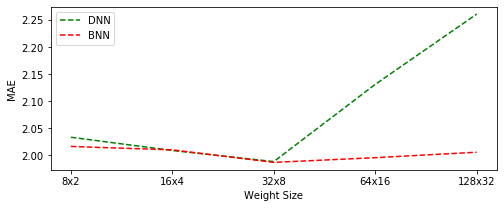

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
x_axis = ['8x2','16x4','32x8','64x16','128x32']
plt.plot(x_axis, mae_test_dnn, color='green', linestyle ='--',label='DNN')
plt.plot(x_axis, mae_test_bnn, color='red', linestyle ='--',label='BNN')
plt.xlabel('Weight Size')
plt.ylabel('MAE')
plt.legend() 

plt.show()

In [4]:
import pandas as pd
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score,mean_squared_error
print (torch.cuda.is_available())
print (torch.version.cuda)
print (torch.cuda.get_device_name(torch.cuda.current_device()))
#model
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)
    
class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
    
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
    def forward(self, x):
        # sample gaussian noise for each weight
        weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())      
        # calculate the weight stds from the rho parameters
        weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
        # calculate samples from the posterior from the sampled noise and mus/stds
        weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
        #torch.cuda.synchronize()
        output = torch.mm(x, weight_sample)
            
        # computing the KL loss term
        #reference: https://github.com/jojonki/AutoEncoders/blob/master/kl_divergence_between_two_gaussians.pdf
        prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
        KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
        KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
        KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
        return output, KL_loss
    
class BBP_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 3))
        self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 3))
        self.layer3 = BayesLinear_Normalq(num_units[1], output_dim, gaussian(0, 3))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        # noise
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([3]))
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer3(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        return x, KL_loss_total
    
class BBP_Model_Wrapper:
    def __init__(self, network, learn_rate=1e-2):
        
        self.learn_rate = learn_rate
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss#nn.MSELoss() 
    
    def fit(self, x, y, no_samples):
        
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        KL_loss_total = 0
        for i in range(no_samples):
            output, KL_loss = self.network(x)
            KL_loss_total = KL_loss_total + KL_loss
            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output, y, self.network.log_noise.exp(), 1) 
            fit_loss_total = fit_loss_total + fit_loss
        
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return total_loss
    
#1.training model
loss_train_bnn = []
loss_test_bnn = []

for layer in [[8,2],[16,4],[32,8],[64,16],[128,32]]:
    net = BBP_Model_Wrapper(network=BBP_Model(input_dim=X_data.shape[1], output_dim=1, num_units=layer))
    train_loss = []
    test_loss = []
    for i in range(500):
        total_loss = net.fit(np.array(X_data), np.array(y_data.to_frame()), no_samples = 100)
        train_loss.append(total_loss)
        total_loss = net.fit(np.array(X_test), np.array(y_test.to_frame()), no_samples = 100)
        test_loss.append(total_loss)
    loss_train_bnn.append(train_loss)
    loss_test_bnn.append(test_loss)
    
print(np.array(loss_train_bnn).shape)
print(np.array(loss_test_bnn).shape)

True
9.0.176
GeForce RTX 2080 Ti
(5, 500)
(5, 500)


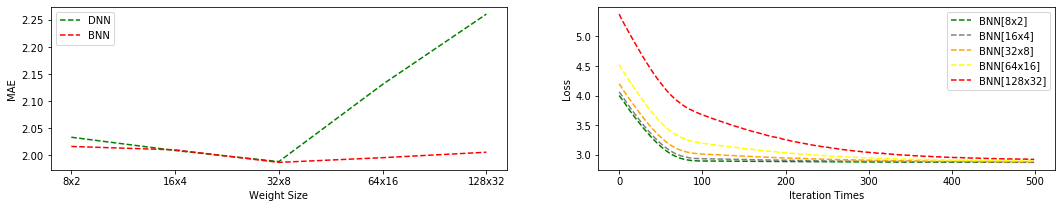

In [11]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.figure(figsize=(18,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3])
plt.subplot(gs[0])
mae_test_dnn = [2.0336599552005126, 2.0092281529926934, 1.9887596132784644, 2.1311577843067444, 2.260688876173998]
mae_test_bnn = [2.0166753080849515, 2.010403798798257, 1.9872894439209405, 1.995980641417999, 2.0060309938212315]
x_axis = ['8x2','16x4','32x8','64x16','128x32']
plt.plot(x_axis, mae_test_dnn, color='green', linestyle ='--',label='DNN')
plt.plot(x_axis, mae_test_bnn, color='red', linestyle ='--',label='BNN')
plt.xlabel('Weight Size')
plt.ylabel('MAE')
plt.legend() 

plt.subplot(gs[1])
x_axis = range(0,500)
#['8x2','16x4','32x8','64x16','128x32']
plt.plot(x_axis, loss_test_bnn[0], color='green', linestyle ='--',label='BNN[8x2]')
plt.plot(x_axis, loss_test_bnn[1], color='gray', linestyle ='--',label='BNN[16x4]')
plt.plot(x_axis, loss_test_bnn[2], color='orange', linestyle ='--',label='BNN[32x8]')
plt.plot(x_axis, loss_test_bnn[3], color='yellow', linestyle ='--',label='BNN[64x16]')
plt.plot(x_axis, loss_test_bnn[4], color='red', linestyle ='--',label='BNN[128x32]')
plt.xlabel('Iteration Times')
plt.ylabel('Loss')
plt.legend() 

plt.show()

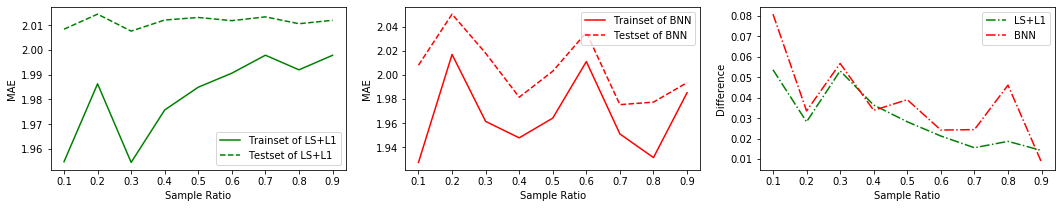

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,3))
x_axis = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.subplot(131)
plt.plot(x_axis, mae_train_L1, color='green', linestyle ='-', label='Trainset of LS+L1')
plt.plot(x_axis, mae_test_L1, color='green', linestyle ='--',label='Testset of LS+L1')
plt.xlabel('Sample Ratio')
plt.ylabel('MAE')
plt.legend() 
plt.subplot(132)
plt.plot(x_axis, mae_train_bnn, color='red', linestyle ='-', label='Trainset of BNN')
plt.plot(x_axis, mae_test_bnn, color='red', linestyle ='--',label='Testset of BNN')
plt.xlabel('Sample Ratio')
plt.ylabel('MAE')
plt.legend() 
plt.subplot(133)
plt.plot(x_axis, list(map(lambda x: x[0]-x[1], zip(mae_test_L1, mae_train_L1))), color='green', linestyle ='-.',label='LS+L1')
plt.plot(x_axis, list(map(lambda x: x[0]-x[1], zip(mae_test_bnn, mae_train_bnn))), color='red', linestyle ='-.',label='BNN')
plt.xlabel('Sample Ratio')
plt.ylabel('Difference')
plt.legend() 

plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score,mean_squared_error
from math import sqrt
import tensorflow as tf
import sys
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

#DNN model
class TF_DNNRegressor_eICU:
    def __init__(self, lr=0.001, dim=52, num_class=1, batchSize=1000, layers=[16, 4]):
        #global parameters
        self.lr = lr
        self.dim = dim # dimensions of sample
        self.num_class = num_class #output 
        self.hidden_layers = layers
        #set network structure
        self.add_placeholders()
        self.add_weight()
        self.add_model()
        self.add_loss()
        self.add_optimizer()
        self.init_sess()
        
    def add_placeholders(self):    
        self.X_input = tf.placeholder("float", [None, self.dim])
        self.Y_input = tf.placeholder("float", [None, self.num_class])
        self.keep_prob = tf.placeholder(tf.float32)  
    
    def add_weight(self):
        # Store layers weight & bias
        #init_uniform = tf.random_uniform_initializer(minval=0, maxval=1, seed=None, dtype=tf.float32)
        self.weights = {
            'w1': tf.Variable(tf.random_normal([self.dim, self.hidden_layers[0]])),
            'w2': tf.Variable(tf.random_normal([self.hidden_layers[0], self.hidden_layers[1]])),
            'wout': tf.Variable(tf.random_normal([self.hidden_layers[1], self.num_class]))
        }
        self.biases = {
            'b1': tf.Variable(tf.random_normal([self.hidden_layers[0]])),
            'b2': tf.Variable(tf.random_normal([self.hidden_layers[1]])),
            'bout': tf.Variable(tf.random_normal([self.num_class]))
        }
        
    def add_model(self):
        # Hidden fully connected layer with 16 neurons
        layer_1 =  tf.add(tf.matmul(self.X_input, self.weights['w1']), self.biases['b1']) 
        # Hidden fully connected layer with 4 neurons
        layer_2 = tf.add(tf.matmul(layer_1, self.weights['w2']), self.biases['b2']) 
        # Output fully connected layer with a neuron for each class
        out_layer =tf.matmul(layer_2, self.weights['wout']) + self.biases['bout'] 
        self.Y_output =  out_layer
    
    def add_loss(self):
        self.loss = tf.losses.mean_squared_error( self.Y_input , self.Y_output ) 
         #self.loss = tf.reduce_sum(tf.losses.absolute_difference( self.Y_input , self.Y_output ) )
            
    def add_optimizer(self):
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.loss)
        
    def init_sess(self):
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        self.config.allow_soft_placement = True
        #self.config.gpu_options.per_process_gpu_memory_fraction = 0.5
        self.sess = tf.Session(config=self.config)
        self.sess.run(tf.global_variables_initializer())
        
#1.training model
loss_train_dnn = []
loss_test_dnn = []
for layer in [[8,2],[16,4],[32,8],[64,16],[128,32]]:
    tf_model = TF_DNNRegressor_eICU(layers=layer)
    #set paramete
    verbose = 10
    batchSize=1000
    num_batches = X_data.shape[0] // batchSize + 1 
    train_loss=[]
    test_loss=[]
    for epoch in range(500):#convergence
        losses = []
        for i in range(num_batches):
            min_idx = i * batchSize
            max_idx = np.min([X_data.shape[0], (i+1)*batchSize])
            X_batch = X_data[min_idx: max_idx]
            Y_batch = y_data.to_frame()[min_idx: max_idx]
            _, tmp_loss = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                             feed_dict={tf_model.X_input: X_batch,tf_model.Y_input: Y_batch, tf_model.keep_prob: 0.6})
            losses.append(tmp_loss)
        train_loss.append(np.mean(losses))
        _, tmp_loss = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                        feed_dict={tf_model.X_input: X_test,tf_model.Y_input: y_test.to_frame(), tf_model.keep_prob: 0.6})
        test_loss.append(tmp_loss)
        
    loss_train_dnn.append(train_loss)
    loss_test_dnn.append(test_loss)
print(np.array(loss_train_dnn).shape)
print(np.array(loss_test_dnn).shape)

(5, 500)
(5, 500)


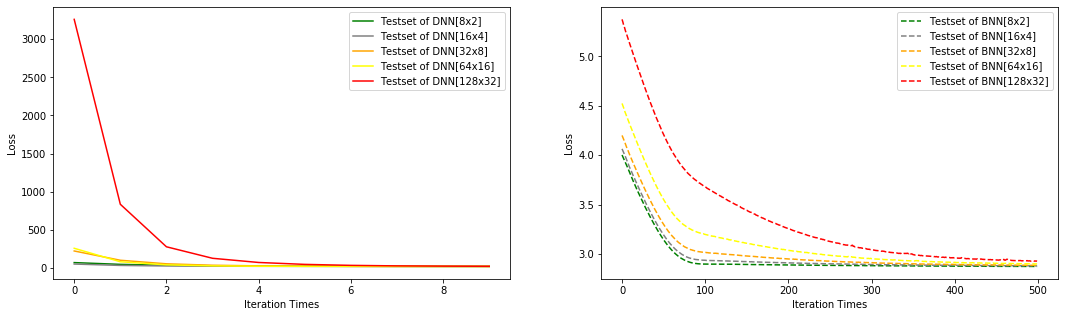

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))
x_axis = range(0,500)
#['8x2','16x4','32x8','64x16','128x32']

plt.subplot(121)
x_axis = range(0,10)
plt.plot(x_axis, loss_test_dnn[0][0:10], color='green', linestyle ='-',label='Testset of DNN[8x2]')
plt.plot(x_axis, loss_test_dnn[1][0:10], color='gray', linestyle ='-',label='Testset of DNN[16x4]')
plt.plot(x_axis, loss_test_dnn[2][0:10], color='orange', linestyle ='-',label='Testset of DNN[32x8]')
plt.plot(x_axis, loss_test_dnn[3][0:10], color='yellow', linestyle ='-',label='Testset of DNN[64x16]')
plt.plot(x_axis, loss_test_dnn[4][0:10], color='red', linestyle ='-',label='Testset of DNN[128x32]')
plt.xlabel('Iteration Times')
plt.ylabel('Loss')
plt.legend() 

plt.subplot(122)
x_axis = range(0,500)
plt.plot(x_axis, loss_test_bnn[0], color='green', linestyle ='--',label='Testset of BNN[8x2]')
plt.plot(x_axis, loss_test_bnn[1], color='gray', linestyle ='--',label='Testset of BNN[16x4]')
plt.plot(x_axis, loss_test_bnn[2], color='orange', linestyle ='--',label='Testset of BNN[32x8]')
plt.plot(x_axis, loss_test_bnn[3], color='yellow', linestyle ='--',label='Testset of BNN[64x16]')
plt.plot(x_axis, loss_test_bnn[4], color='red', linestyle ='--',label='Testset of BNN[128x32]')
plt.xlabel('Iteration Times')
plt.ylabel('Loss')
plt.legend() 

plt.show()